In [1]:
from utils import *
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import numpy as np
import cupy as cp
import pandas as pd
import math
import json
from PIL import Image, ImageDraw
from collections import defaultdict
import itertools
from hdv import *
from sklearn.model_selection import train_test_split

In [2]:
config = Config()
IMAGE_SIZE = config.sample_size

device_marker = np.empty(1)
xp = cp.get_array_module(device_marker)

RNG = xp.random.default_rng()

In [3]:
%%time
IMAGES_ALL = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE
        assert image.mode == 'L'
        image_index = len(IMAGES_ALL)
        IMAGES_ALL.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES_ALL) == len(IMAGES_METADATA)
IMAGES_ALL = np.array(IMAGES_ALL)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES_ALL)} images')

  0%|          | 0/10001 [00:00<?, ?it/s]

Loaded 10000 images
CPU times: user 1.38 s, sys: 141 ms, total: 1.52 s
Wall time: 1.52 s


In [4]:
images_train_indices, images_test_indices = train_test_split(range(len(IMAGES_ALL)))
IMAGES_TRAIN = IMAGES_ALL[images_train_indices]
IMAGES_METADATA_TRAIN = IMAGES_METADATA[images_train_indices]
IMAGES_TEST = IMAGES_ALL[images_test_indices]
IMAGES_METADATA_TEST = IMAGES_METADATA[images_test_indices]

del IMAGES_ALL
del IMAGES_METADATA

IMAGES_TRAIN.shape, IMAGES_TEST.shape

((7500, 16384), (2500, 16384))

In [5]:
def matrix_to_image(m):
    return Image.frombytes('L', size=(IMAGE_SIZE, IMAGE_SIZE), data=m.reshape(IMAGE_SIZE, IMAGE_SIZE).astype(xp.uint8))


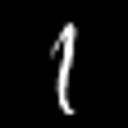
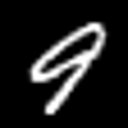
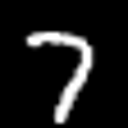
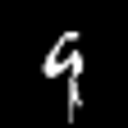
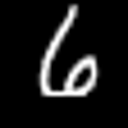
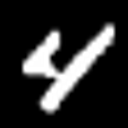
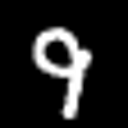
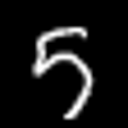
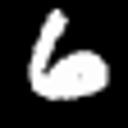
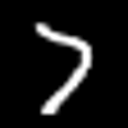
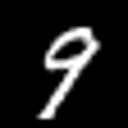
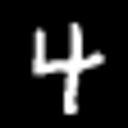
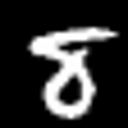
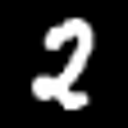
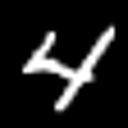
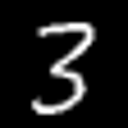

In [6]:
count = 8

def get_some_random_images_and_labels(images, images_metadata, count):
    indices = RNG.integers(len(images), size=(count,))
    labels = list(images_metadata[indices]['value'])
    images = list(map(lambda i: matrix_to_image(images[i]), indices))
    return images, labels

train_images, train_labels = get_some_random_images_and_labels(IMAGES_TRAIN, IMAGES_METADATA_TRAIN, count)
test_images, test_labels = get_some_random_images_and_labels(IMAGES_TEST, IMAGES_METADATA_TEST, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [7]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE * SENSOR_GROUP_SIZE
RETINA_SIZE = 16
RETINA_SQUARE = RETINA_SIZE * RETINA_SIZE


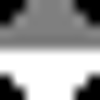
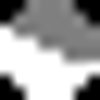
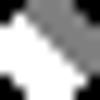
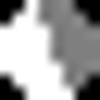
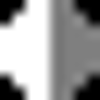
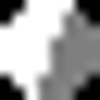
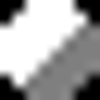
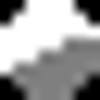
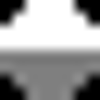
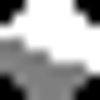
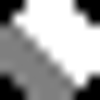
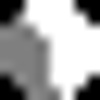
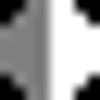
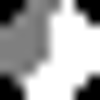
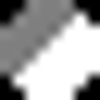
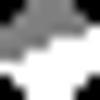

In [8]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

In [9]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [10]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 np.float64(28.0),
 np.int64(26),
 np.int64(30),
 np.float64(1.4142135623730951))


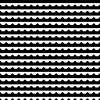
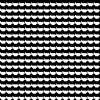
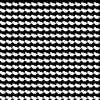
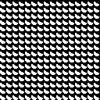
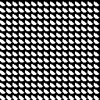
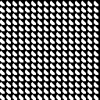
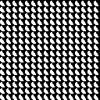
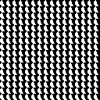
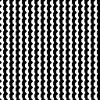
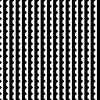
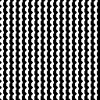
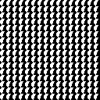
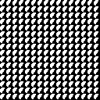
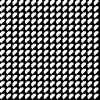
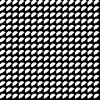
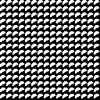
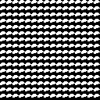
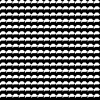
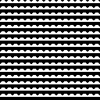
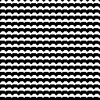
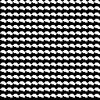
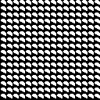
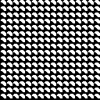
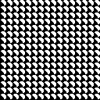
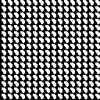
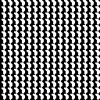
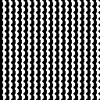
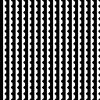
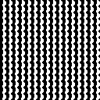
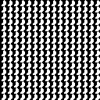
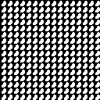
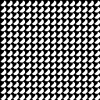
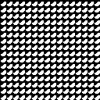
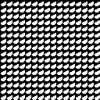
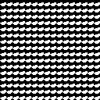
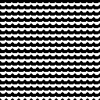

In [11]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
       
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [12]:
SPECIFIC_SAMPLES = xp.array(list(map(xp.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [13]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = np.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = np.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

In [14]:
assert xp.array_equal(xp.unique(SPECIFIC_SAMPLES), [0, 1])

specific_samples_sense_pos = RETINA_POS @ SPECIFIC_SAMPLES.T
specific_samples_sense_neg = RETINA_NEG @ SPECIFIC_SAMPLES.T
specific_samples_sense_pos = specific_samples_sense_pos.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_neg = specific_samples_sense_neg.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_ref = specific_samples_sense_pos.copy() # reference
assert specific_samples_sense_pos.shape == specific_samples_sense_neg.shape

# Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
# Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
# Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
# For specific samples situation is more straighforward, since is liminiscense is binary (0 or 1)
for y in range(specific_samples_sense_ref.shape[0]):
    for x in range(specific_samples_sense_ref.shape[1]):
        # Matrix of how each group of sensors (rows) perceives each of specific samples (columns)
        perceive_matrix = specific_samples_sense_ref[y, x]
        assert perceive_matrix.shape == (pow(SENSOR_GROUP_SIZE, 2), SPECIFIC_SAMPLES.shape[0])
        cond1 = (perceive_matrix.T / group_sensors_ones).T >= 0.5 # At least half of a positive area of each of sensors is activated

        perceive_matrix_pos = specific_samples_sense_pos[y, x]
        perceive_matrix_neg = xp.abs(specific_samples_sense_neg[y, x])
        assert perceive_matrix_pos.shape == perceive_matrix.shape
        assert perceive_matrix_neg.shape == perceive_matrix.shape

        cond2 = perceive_matrix_pos > perceive_matrix_neg # There is more activation on positive areas than on negative
        assert cond1.shape == cond2.shape
        specific_samples_sense_ref[y, x] = (cond1 & cond2).astype(float)

for i in range(SPECIFIC_SAMPLES.shape[0]):
    v = specific_samples_sense_ref[0, 0, :, i]
    print(f'{v} => {(v == 1).sum()}')

    for y in range(specific_samples_sense_ref.shape[0]):
        for x in range(specific_samples_sense_ref.shape[1]):
            assert xp.array_equal(v, specific_samples_sense_ref[y, x, :, i])

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 7
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 7
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 

In [15]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [16]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images, active_sensors=None):
    active_sensors = xp.ones((RETINA_SQUARE * SENSOR_GROUP_SQUARE, 1)) if active_sensors is None else active_sensors
    assert active_sensors.shape == (RETINA_POS.shape[0], 1)
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    effective_retina_pos = RETINA_POS * active_sensors
    effective_retina_neg = RETINA_NEG * active_sensors
    sense_area = (effective_retina_pos @ image_masks.T).T # for check of illuminated area
    sense_level = (effective_retina_pos @ images.T).T # for check of absolute illumination
    sense_neg_level = (effective_retina_neg @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), RETINA_SQUARE * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [17]:
def get_uniform_drifts():
    drifts = []
    drift_range = range(-4, 6, 2)
    
    for i in drift_range:
        for j in drift_range:
            drifts.append((i,j))   
    
    return drifts

In [18]:
def get_image_drifts(image, drifts):
    images = []

    for drift in drifts:
        image_drifted = image.reshape(IMAGE_SIZE, IMAGE_SIZE)
        image_drifted = np.roll(image_drifted, drift[0], axis=0)
        rows_to_wipeout = [min(drift[0], 0) + i for i in range(abs(drift[0]))]
        image_drifted[rows_to_wipeout,:] = 0
        image_drifted = np.roll(image_drifted, drift[1], axis=1)
        cols_to_wipeout = [min(drift[1], 0) + i for i in range(abs(drift[1]))]
        image_drifted[:,cols_to_wipeout] = 0
        image_drifted = image_drifted.reshape(-1)
        images.append(image_drifted)

    return xp.array(images)


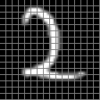
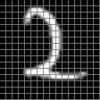
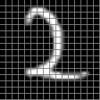
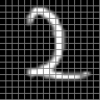
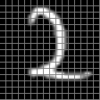
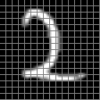
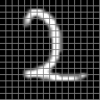
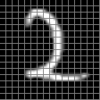
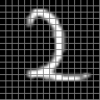
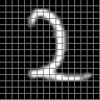
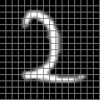
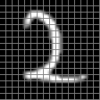
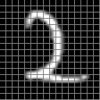
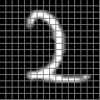
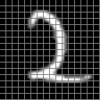
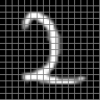
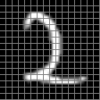
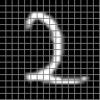
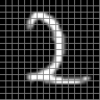
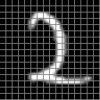
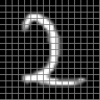
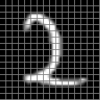
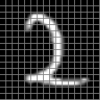
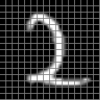
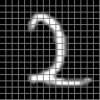
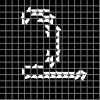
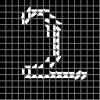
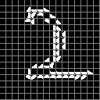
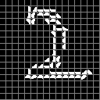
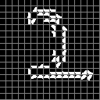
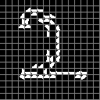
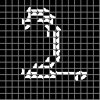
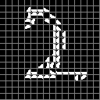
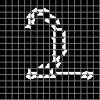
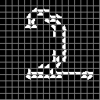
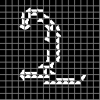
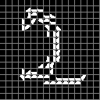
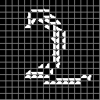
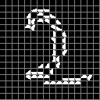
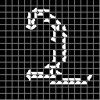
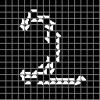
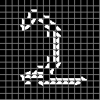
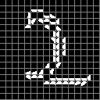
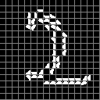
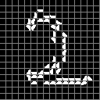
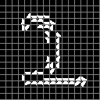
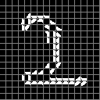
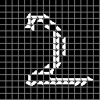
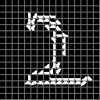
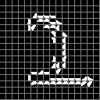

In [19]:
image_index = 6835
image = IMAGES_TRAIN[image_index]
images = get_image_drifts(image, get_uniform_drifts())
sensor_activationss = sense_images(images)
sensor_map_images = []

for sensor_activations in sensor_activationss:
    sensor_activations = sensor_activations.reshape(RETINA_SIZE, RETINA_SIZE, SENSOR_GROUP_SQUARE)
    sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
    sensor_map_image = xp.zeros((sz, sz))

    for y in range(RETINA_SIZE):
        for x in range(RETINA_SIZE):
            sensors_in_group = sensor_activations[y, x]
            assert sensors_in_group.shape == (SENSOR_GROUP_SQUARE,)

            if xp.any(sensors_in_group > 0):
                # Find most similar reaction among specific samples of reactions
                a = sensors_in_group
                b = specific_samples_sense_ref[y, x, :]
                sense_vector_cos_sim = (a @ b)/(xp.linalg.norm(a) * xp.linalg.norm(b, axis=0))
                best_i = xp.argmax(sense_vector_cos_sim)
                most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
                srfs = SENSOR_RECEPTIVE_FIELD_SIZE
                xp.copyto(sensor_map_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    sensor_map_images.append(sensor_map_image * 255)

images_to_display = list(images) + sensor_map_images
images_to_display = map(lambda x: matrix_to_image(x), images_to_display)
images_to_display = map(lambda x: lay_grid(x, SENSOR_RECEPTIVE_FIELD_SIZE), images_to_display)
images_to_display = map(lambda x: x.resize((100, 100)), images_to_display)
display_images_grid(list(images_to_display), col_count=len(images))

In [19]:
COS_SIM_THRESHOLD = 0.075
hdv = Hdv(10_000, xp)

In [20]:
SENSOR_GROUP_HDV_DB = defaultdict(hdv)

In [21]:
IMAGE_HDV_DB = xp.zeros(shape=(0, hdv.N), dtype='b')
IMAGE_NORM_HDV_DB = xp.zeros(shape=(0, hdv.N))
IMAGE_INDEX_TO_IMAGE_NORM_HDV_INDEX = dict()
IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX = dict()

In [22]:
count = 3000
sensor_activationss = sense_images(IMAGES_TRAIN[:count]) # shape: image, sensor_activations for an image. E.g. (count, 4096)

for image_index, sensor_activations in tqdm(enumerate(sensor_activationss), total=sensor_activationss.shape[0]):
    # sensor_activations = sensor activations for given image; shape=(4096,)
    image_hdv = []
    
    for i in range(0, len(sensor_activations), SENSOR_GROUP_SQUARE):
        sensor_activations_group = sensor_activations[i:i+SENSOR_GROUP_SQUARE]

        if xp.any(sensor_activations_group > 0):
            sensor_activations_group_pulp = ''.join(map(str, sensor_activations_group.tolist()))
            sensor_activations_group_code = f'[{sensor_activations_group_pulp}]@{i}'
            image_hdv.append(SENSOR_GROUP_HDV_DB[sensor_activations_group_code])

    if not image_hdv: # empty image (neither sensor got activated)
        print(f'WARN! Empty image detected #{image_index}')
        continue

    image_hdv = hdv.bundle_noties(image_hdv)
    image_norm_hdv = hdv.normalize(image_hdv)

    cos_sims = IMAGE_NORM_HDV_DB @ image_norm_hdv # this will compute cos sim against all HDVs in DB

    for _ in range(1):
        if cos_sims.size > 0:
            max_cos_sim_index = xp.argmax(cos_sims)
    
            if cos_sims[max_cos_sim_index] >= COS_SIM_THRESHOLD:
                break
    else:
        # No similar image found, register new one
        IMAGE_HDV_DB = xp.append(IMAGE_HDV_DB, [image_hdv], axis=0)
        IMAGE_NORM_HDV_DB = xp.append(IMAGE_NORM_HDV_DB, [image_norm_hdv], axis=0)
        norm_hdv_index = IMAGE_NORM_HDV_DB.shape[0] - 1
        assert norm_hdv_index >= 0
        IMAGE_INDEX_TO_IMAGE_NORM_HDV_INDEX[image_index] = norm_hdv_index
        IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX[norm_hdv_index] = image_index

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
def find_image_prototypes1(image):
    image_drifts = get_image_drifts(image, get_uniform_drifts())
    sensor_activationss = sense_images(image_drifts) # shape: image_drift, sensor_activations for image_drift. E.g. (25, 4096)
    image_drift_hdvs = []
    result = []
    
    for sensor_activations in sensor_activationss:
        # sensor_activations = sensor activations for next image_drift, e.g. shape=(4096,)
        image_drift_hdv = []
        
        for i in range(0, len(sensor_activations), SENSOR_GROUP_SQUARE):
            sensor_activations_group = sensor_activations[i:i+SENSOR_GROUP_SQUARE]

            if xp.any(sensor_activations_group > 0):
                sensor_activations_group_pulp = ''.join(map(str, sensor_activations_group.tolist()))
                sensor_activations_group_code = f'[{sensor_activations_group_pulp}]@{i}'
                image_drift_hdv.append(SENSOR_GROUP_HDV_DB[sensor_activations_group_code])

        if not image_drift_hdv: # empty image (neither sensor got activated)
            continue

        image_drift_hdv = hdv.bundle_noties(image_drift_hdv)
        image_drift_norm_hdv = hdv.normalize(image_drift_hdv)

        cos_sims = IMAGE_NORM_HDV_DB @ image_drift_norm_hdv # this will compute cos sim against all HDVs in DB

        if cos_sims.size > 0:
            max_cos_sim_index = xp.argmax(cos_sims)

            if max_cos_sim_index > -1 and cos_sims[max_cos_sim_index] >= COS_SIM_THRESHOLD:
                rec = (IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX[max_cos_sim_index], cos_sims[max_cos_sim_index])
                result.append(rec)

    result.sort(key=lambda x: -x[1]) # sort asc by cos sim 
    return result

In [24]:
count = 100
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]
inference_table = []

def get_image_safe(images_dataset, index):
    if index < 0:
        return Image.new('L', size=(1,1), color=255)
        
    return matrix_to_image(images_dataset[index])

test_image_indices = RNG.choice(len(IMAGES_TEST), count, replace=False)

for image_index in tqdm(test_image_indices):
    images_row.append(image_index)
    true_value = IMAGES_METADATA_TEST[image_index]['value']
    images_captions.append(f'#{image_index}, val={true_value}')
    inference_record = [image_index, int(true_value)]
    
    image_protos = find_image_prototypes1(IMAGES_TEST[image_index])

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos):
        if row is None:
            break
            
        image_proto_index, cos_sim = (-1, 0) if image_proto is None else image_proto
        row.append(image_proto_index)
        inferred_value = int(IMAGES_METADATA_TRAIN[image_proto_index]['value']) if image_proto_index >= 0 else -1
        captions.append(f'#{image_proto_index}, sim={cos_sim:.2f}, val={inferred_value}')

        if len(inference_record) < 3:
            inference_record.append(inferred_value)

    inference_table.append(inference_record)

test_images = list(map(lambda i: get_image_safe(IMAGES_TEST, i), images_row))
train_images = list(map(lambda i: get_image_safe(IMAGES_TRAIN, i), itertools.chain.from_iterable(image_protos_rows)))
df = pd.DataFrame(inference_table, columns=['test_image_index', 'true value', 'infer. value'])
df['is_match'] = df['true value'] == df['infer. value']
print(f'ACCURACY = {df['is_match'].sum() / len(df) * 100:.2f}% (matched {df['is_match'].sum()} of {len(df)})')
df

  0%|          | 0/100 [00:00<?, ?it/s]

ACCURACY = 72.00% (matched 72 of 100)


,test_image_index,true value,infer. value,is_match
0,2078,2,0,False
1,1018,6,6,True
2,1276,0,0,True
3,229,7,7,True
4,2108,7,7,True
...,...,...,...,...
95,2034,0,0,True
96,730,0,0,True
97,1059,7,4,False
98,2001,1,1,True



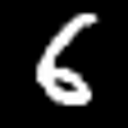
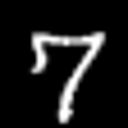
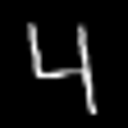
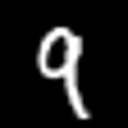
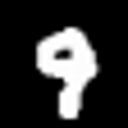
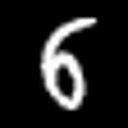
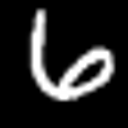
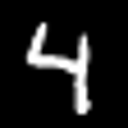
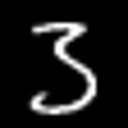
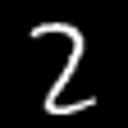
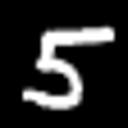
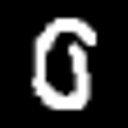
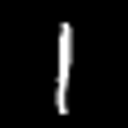
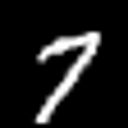
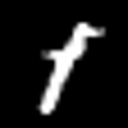
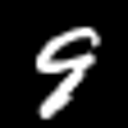
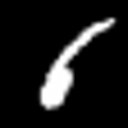
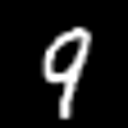
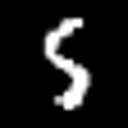
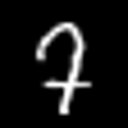
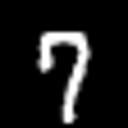
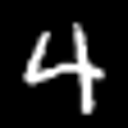
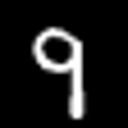
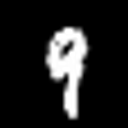
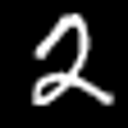
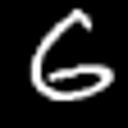
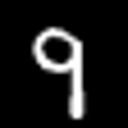
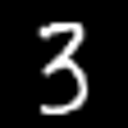
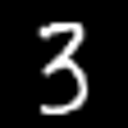
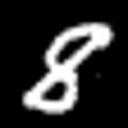
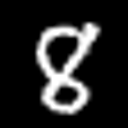
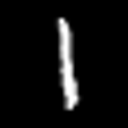
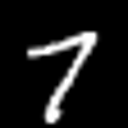
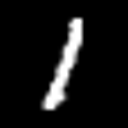
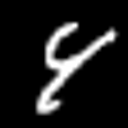
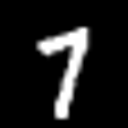
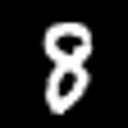
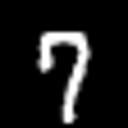
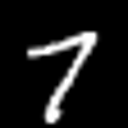
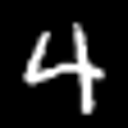
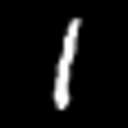
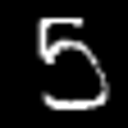
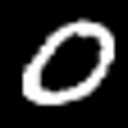
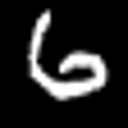
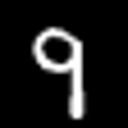
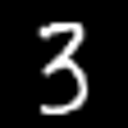
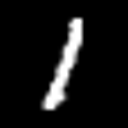
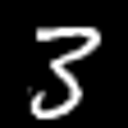
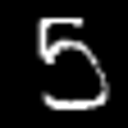
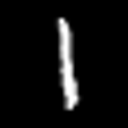
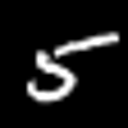
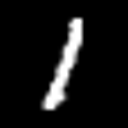
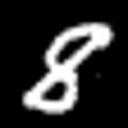
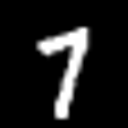
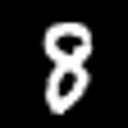
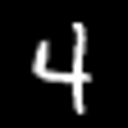
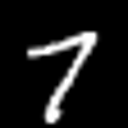
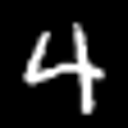
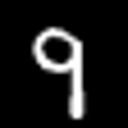
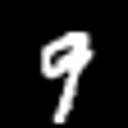
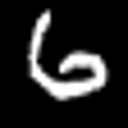
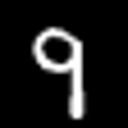
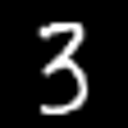
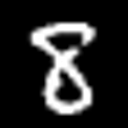
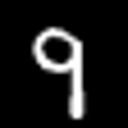
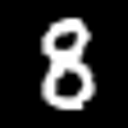
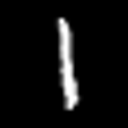
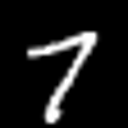
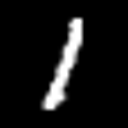
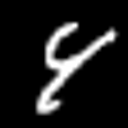
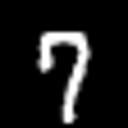
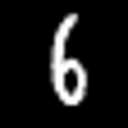
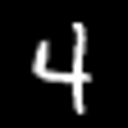

In [102]:
display_images_grid(test_images+train_images,
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))

In [21]:
class CorticalColumn(object):
    def __init__(self, width):
        self.sensor_group_indices = RNG.choice(RETINA_SQUARE, width, replace=False)
        self.sensor_group_indices *= SENSOR_GROUP_SQUARE
        assert xp.all(xp.unique_counts(self.sensor_group_indices).counts == 1)
        self.stage_norm_hdvs = []
        self.conso_norm_hdvs = xp.zeros(shape=(0, hdv.N))
        self.stage_norm_hdv_index_to_image_index = dict()
        self.conso_norm_hdv_index_to_image_index = dict()

    def remember(self, norm_hdv, image_index):
        assert image_index > -1
        assert norm_hdv.shape == (hdv.N,)
        self.stage_norm_hdvs.append(norm_hdv)
        norm_hdv_index = len(self.stage_norm_hdvs) - 1
        assert norm_hdv_index > -1
        self.stage_norm_hdv_index_to_image_index[norm_hdv_index] = image_index

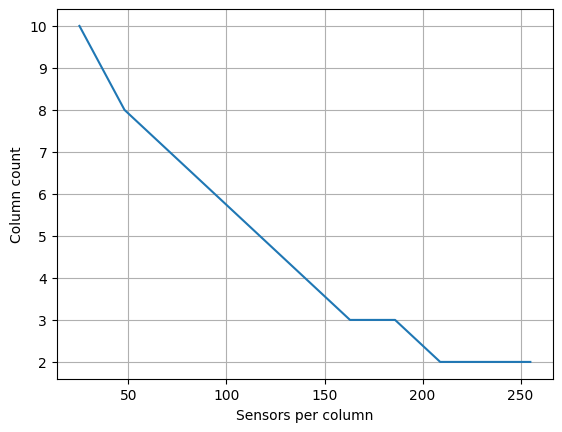

(    width  count
 0      25     10
 1      48      8
 2      71      7
 3      94      6
 4     117      5
 5     140      4
 6     163      3
 7     186      3
 8     209      2
 9     232      2
 10    255      2,
 np.int64(52))

In [22]:
CORTICAL_COLUMN_COUNT = 50 # circa

width_levels = 10
width_lo = RETINA_SQUARE // 10
width_hi = RETINA_SQUARE
width_steps = (width_hi - width_lo) // width_levels
xs = list(range(width_lo, width_hi, width_steps))
ys = []
l = 2
    
for x in range(len(xs)):
    x = x / len(xs)
    y = l * np.exp(-l * x)
    ys.append(y)

ys = np.round(np.array(ys) * (CORTICAL_COLUMN_COUNT / np.sum(ys)), decimals=0).astype(int)
######
CORTICAL_COLUMNS = []

for width, count in zip(xs, ys):
    assert count >= 1
    
    for _ in range(count):
        CORTICAL_COLUMNS.append(CorticalColumn(width))

assert len(CORTICAL_COLUMNS) >= CORTICAL_COLUMN_COUNT
    
######
plt.plot(xs, ys)
plt.xlabel('Sensors per column')
plt.ylabel('Column count')
plt.grid()
plt.show()
pd.DataFrame({'width': xs, 'count': ys}), np.sum(ys)

In [23]:
count = 3000
sensor_activationss = sense_images(IMAGES_TRAIN[:count]) # shape: image, sensor_activations for an image. E.g. (count, 4096)

for image_index, sensor_activations in tqdm(enumerate(sensor_activationss), total=count):
    # sensor_activations = sensor activations for given image; shape=(4096,)
    # Ощупываем image с разных сторон, аггресивно запоминаем всё подряд
    for column_index, column in enumerate(CORTICAL_COLUMNS):
        column_norm_hdv = []
    
        for sensor_group_index in column.sensor_group_indices:
            sensor_group = sensor_activations[sensor_group_index:sensor_group_index+SENSOR_GROUP_SQUARE]

            if xp.any(sensor_group > 0):
                sensor_group_pulp = ''.join(map(str, sensor_group.tolist()))
                sensor_group_code = f'[{sensor_group_pulp}]@{sensor_group_index}'
                column_norm_hdv.append(SENSOR_GROUP_HDV_DB[sensor_group_code])

        if column_norm_hdv:
            column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
            column_norm_hdv = hdv.normalize(column_norm_hdv)
            column.remember(column_norm_hdv, image_index)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
# Consolidate memory
for column in CORTICAL_COLUMNS:
    if column.stage_norm_hdvs:
        offset = column.conso_norm_hdvs.shape[0]
        offsetted_mapping = map(lambda p: (p[0] + offset, p[1]), column.stage_norm_hdv_index_to_image_index.items())
        column.conso_norm_hdvs = xp.append(column.conso_norm_hdvs, column.stage_norm_hdvs, axis=0)
        column.conso_norm_hdv_index_to_image_index.update(offsetted_mapping)

    column.stage_norm_hdvs = []
    column.stage_norm_hdv_index_to_image_index = dict()

In [25]:
def get_consensus_table(sensor_activations):
    table = defaultdict(list)
    
    for column_index, column in enumerate(CORTICAL_COLUMNS):
        column_norm_hdv = []
    
        for sensor_group_index in column.sensor_group_indices:
            sensor_group = sensor_activations[sensor_group_index:sensor_group_index+SENSOR_GROUP_SQUARE]

            if xp.any(sensor_group > 0):
                sensor_group_pulp = ''.join(map(str, sensor_group.tolist()))
                sensor_group_code = f'[{sensor_group_pulp}]@{sensor_group_index}'
                column_norm_hdv.append(SENSOR_GROUP_HDV_DB[sensor_group_code])

        if column_norm_hdv:
            column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
            column_norm_hdv = hdv.normalize(column_norm_hdv)
        
            cos_sims = column.conso_norm_hdvs @ column_norm_hdv # this will compute cos sim against all HDVs
            candidate_hdv_indices = xp.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)

            for candidate_hdv_index in candidate_hdv_indices:
                cos_sim = cos_sims[candidate_hdv_index]
                candidate_image_index = column.conso_norm_hdv_index_to_image_index[candidate_hdv_index]
                table['column_index'].append(column_index)
                table['image_index'].append(candidate_image_index)
                table['sim'].append(cos_sim)

    return table

In [26]:
%%time
count = 100
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]
inference_table = []

def get_image_safe(images_dataset, index):
    if index < 0:
        return Image.new('L', size=(1,1), color=255)
        
    return matrix_to_image(images_dataset[index])

test_image_indices = RNG.choice(len(IMAGES_TEST), count, replace=False)
    
for image_index in tqdm(test_image_indices):
    image = IMAGES_TEST[image_index]
    images_row.append(image_index)
    true_value = IMAGES_METADATA_TEST[image_index]['value']
    images_captions.append(f'#{image_index}, val={true_value}')
    inference_record = [image_index, int(true_value)]
    
    drifts = RNG.normal(0, 5, size=(50, 2)).astype(int)
    image_variants = get_image_drifts(image, drifts)
    sensor_activations_of_image_variants = sense_images(image_variants)

    for image_variant_sensor_activations in sensor_activations_of_image_variants:
        consensus_table = get_consensus_table(image_variant_sensor_activations)

        if len(consensus_table) == 0:
            continue
            
        consensus_table = pd.DataFrame(consensus_table, columns=['column_index', 'image_index', 'sim'])
        assert len(consensus_table) > 0
        image_protos = pd.pivot_table(consensus_table, 
                                      index=['image_index'], 
                                      values=['sim', 'column_index'], 
                                      aggfunc={'sim': 'sum', 'column_index': 'nunique'},
                                      sort=False)
        image_protos = image_protos[(image_protos[('column_index')] >= len(CORTICAL_COLUMNS) * 0.75)]
        image_protos.sort_values(by=['column_index', 'sim'], ascending=[False, False], inplace=True)

        if len(image_protos) > 0:
            break
    else:
        image_protos = pd.DataFrame(columns=['dummy'])

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos.iterrows()):
        if row is None:
            break
            
        image_proto_index, votes, cos_sim = (-1, 0, 0) if image_proto is None else (int(image_proto[0]), int(image_proto[1]['column_index']), image_proto[1]['sim'])
        row.append(image_proto_index)
        inferred_value = int(IMAGES_METADATA_TRAIN[image_proto_index]['value']) if image_proto_index >= 0 else -1
        captions.append(f'#{image_proto_index}, votes={votes}, sim={cos_sim:.2f}, val={inferred_value}')

        if len(inference_record) < 3:
            inference_record.append(inferred_value)

    inference_table.append(inference_record)

test_images = list(map(lambda i: get_image_safe(IMAGES_TEST, i), images_row))
train_images = list(map(lambda i: get_image_safe(IMAGES_TRAIN, i), itertools.chain.from_iterable(image_protos_rows)))
df = pd.DataFrame(inference_table, columns=['test_image_index', 'true value', 'infer. value'])
df['is_match'] = df['true value'] == df['infer. value']
print(f'ACCURACY = {df['is_match'].sum() / len(df) * 100:.2f}% (matched {df['is_match'].sum()} of {len(df)})')
df

  0%|          | 0/100 [00:00<?, ?it/s]

ACCURACY = 61.00% (matched 61 of 100)
CPU times: user 1h 33min 56s, sys: 35.3 s, total: 1h 34min 31s
Wall time: 9min 36s


,test_image_index,true value,infer. value,is_match
0,84,7,7,True
1,452,2,2,True
2,1578,6,5,False
3,2494,0,0,True
4,849,8,5,False
...,...,...,...,...
95,929,4,9,False
96,2351,0,0,True
97,449,9,9,True
98,414,9,2,False



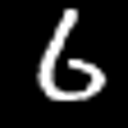
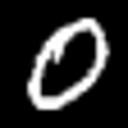
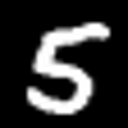
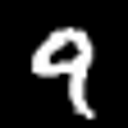
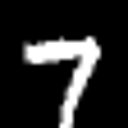
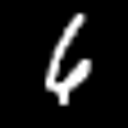
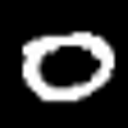
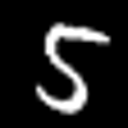
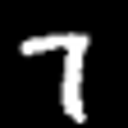
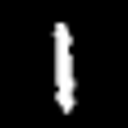
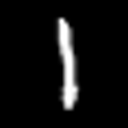
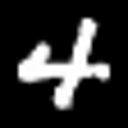
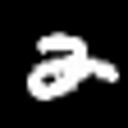
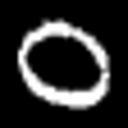
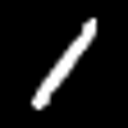
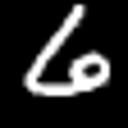
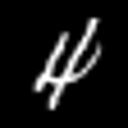
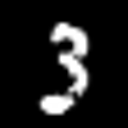
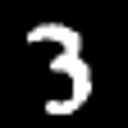
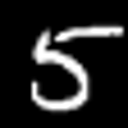
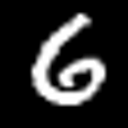
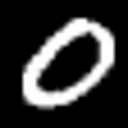
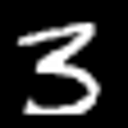
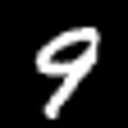
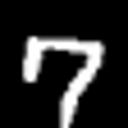
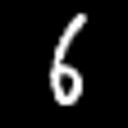
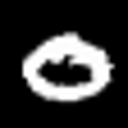
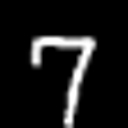
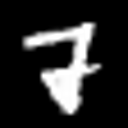
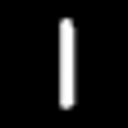
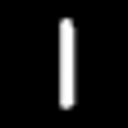
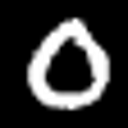
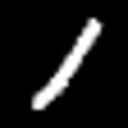
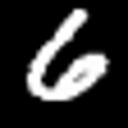
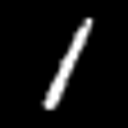
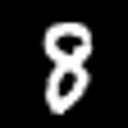
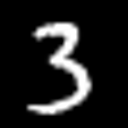
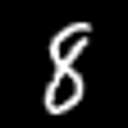
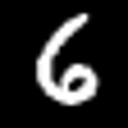
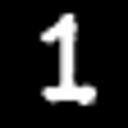
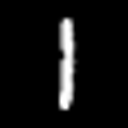
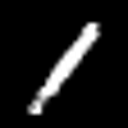
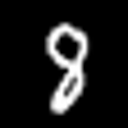
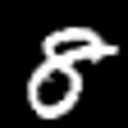
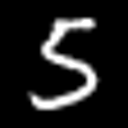
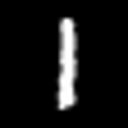
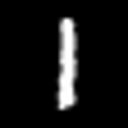

In [104]:
display_images_grid(test_images+train_images,
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))